In [1]:
import numpy as np

import sys

import numpy as np
from time import sleep
import sys
import keras.backend as K

from keras.models import Model, Sequential
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
# IRIS DATA
_X = np.array([[float(j) for j in i.rstrip().split(",")[:-1]] for i in open("iris.data").readlines()][:-1])
_Y = np.array([0 for i in range(100)] + [1 for i in range(50)])

In [3]:
# MNIST DATA
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000,28, 28)
Y = mnist.train._labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Linear interpolation of samples

In [9]:
'''
Input: numpy array of a sample
Optional inputs:
    - reference: reference values (defaulted to 0s).
    - steps: # steps from reference values to the actual sample.
Output: list of numpy arrays to integrated over.
'''

def linearly_interpolate(sample, reference=None, num_steps=50):
    # Use default reference values if reference is not specified
    if reference is None: reference = np.zeros(sample.shape);
    
    # Reference and sample shape needs to match exactly
    assert sample.shape == reference.shape
        
    # Calcuated stepwise difference from reference to the actual sample.
    ret = np.zeros(tuple([num_steps] +[i for i in sample.shape]))
    for s in range(num_steps):
        ret[s] = reference+(sample-reference)*(s*1.0/num_steps)
        
    return ret, num_steps, (sample-reference)*(1.0/num_steps)

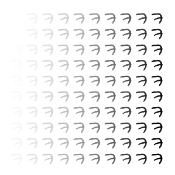

In [10]:
# Interpolate to 0
samples, num_steps, step_sizes = linearly_interpolate(X[0].reshape(28,28), num_steps=100)

image = np.zeros((int(np.ceil(num_steps/10)*28), 10*28))
count = 0
for i in range(10):
    for j in range(int(np.ceil(num_steps/10))):
        s = samples[count]
        count += 1
        image[j*28:(j+1)*28, i*28:(i+1)*28] = s
plt.figure(figsize=(int(np.ceil(num_steps/10)*0.25), 10*0.25))
plt.imshow(image)
plt.xticks([],[])
plt.yticks([],[])
plt.show()

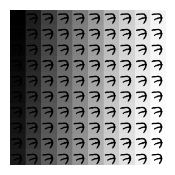

In [11]:
# Interpolate to 1
samples, num_steps, step_sizes = linearly_interpolate(X[0].reshape(28,28), np.ones((28,28)), num_steps=100)

image = np.zeros((int(np.ceil(num_steps/10)*28), 10*28))
count = 0
for i in range(10):
    for j in range(int(np.ceil(num_steps/10))):
        s = samples[count]
        count += 1
        image[j*28:(j+1)*28, i*28:(i+1)*28] = s
plt.figure(figsize=(int(np.ceil(num_steps/10)*0.25), 10*0.25))
plt.imshow(image)
plt.xticks([],[])
plt.yticks([],[])
plt.show()

# Integrated gradients

In [4]:
################################################################
# Implemented by Naozumi Hiranuma (hiranumn@uw.edu)            #
#                                                              #
# Kears-compatible implmentation of Integrated Gradients       # 
# proposed in "Axiomatic attribution for deep neuron networks" #
# (https://arxiv.org/abs/1703.01365).                          #
#                                                              #
# Keywords: Shapley values, interpretable machine learning     #
################################################################
import numpy as np
from time import sleep
import sys
import keras.backend as K

from keras.models import Model, Sequential

'''
Integrated gradients approximates Shapley values by integrating partial
gradients with respect to input features from reference input to the
actual input. The following class implements this concept.
'''
class integrated_gradients:
    # model: Keras model that you wish to explain.
    # outchannels: In case the model are multi tasking, you can specify which channels you want.
    def __init__(self, model, outchannels=[], verbose=1):
    
        # Bacnend: either tensorflow or theano)
        self.backend = K.backend()
        
        #load model supports keras.Model and keras.Sequential
        if isinstance(model, Sequential):
            self.model = model.model
        elif isinstance(model, Model):
            self.model = model
        else:
            print "Invalid input model"
            return -1
        
        #load input tensors
        self.input_tensors = []
        for i in self.model.inputs:
            self.input_tensors.append(i)
        # The learning phase flag is a bool tensor (0 = test, 1 = train)
        # to be passed as input to any Keras function that uses 
        # a different behavior at train time and test time.
        self.input_tensors.append(K.learning_phase())
        
        #If outputchanel is specified, use it.
        #Otherwise evalueate all outputs.
        self.outchannels = outchannels
        if len(self.outchannels) == 0: 
            if verbose: print "Evaluated output channel (0-based index): All"
            if K.backend() == "tensorflow":
                self.outchannels = range(self.model.output.shape[1]._value)
            elif K.backend() == "theano":
                self.outchannels = range(model1.output._keras_shape[1])
        else:
            if verbose: 
                print "Evaluated output channels (0-based index):", 
                for i in self.outchannels: print i
                print
                
        #Build gradient functions for desired output channels.
        self.get_gradients = {}
        if verbose: print "Building gradient functions"
        
            # Evaluate over all channels.
        for c in self.outchannels:
            # Get tensor that calcuates gradient
            if K.backend() == "tensorflow":
                gradients = self.model.optimizer.get_gradients(self.model.output[:, c], self.model.input)
            if K.backend() == "theano":
                gradients = self.model.optimizer.get_gradients(self.model.output[:, c].sum(), self.model.input)
                
            # Build computational graph that calculates the tensfor given inputs
            self.get_gradients[c] = K.function(inputs=self.input_tensors, outputs=gradients)
            
            # This takes a lot of time for a big model with many tasks.
            # So lets pring the progress.
            if verbose:
                sys.stdout.write('\r')
                sys.stdout.write("Progress: "+str(int((c+1)*1.0/len(self.outchannels)*1000)*1.0/10)+"%")
                sys.stdout.flush()
        # Done
        if verbose: print "\nDone."
            
                
    '''
    Input: sample to explain, channel to explain
    Optional inputs:
        - reference: reference values (defaulted to 0s).
        - steps: # steps from reference values to the actual sample.
    Output: list of numpy arrays to integrated over.
    '''
    def explain(self, sample, outc=0, reference=False, num_steps=50, verbose=0):
        
        # Each element for each input stream.
        samples = []
        numsteps = []
        step_sizes = []
        
        # If multiple inputs are present, feed them as list of np arrays. 
        if isinstance(sample, list):
            #If reference is present, reference and sample size need to be equal.
            if reference != False: 
                assert len(sample) == len(reference)
            for i in range(len(sample)):
                if reference == False:
                    _output = integrated_gradients.linearly_interpolate(sample[i], False, num_steps)
                else:
                    _output = integrated_gradients.linearly_interpolate(sample[i], False, num_steps)
                samples.append(_output[0])
                numsteps.append(_output[1])
                step_sizes.append(_output[2])
        
        # Or you can feed just a single numpy arrray. 
        elif isinstance(sample, np.ndarray):
            _output = integrated_gradients.linearly_interpolate(sample, reference, num_steps)
            samples.append(_output[0])
            numsteps.append(_output[1])
            step_sizes.append(_output[2])
            
        # Desired channel must be in the list of outputchannels
        assert outc in self.outchannels
        if verbose: print "Explaning the "+str(self.outchannels[outc])+"th output."
            
        # For tensorflow backend
        _input = []
        for s in samples:
            _input.append(s)
        _input.append(0)
        
        if K.backend() == "tensorflow": 
            gradients = self.get_gradients[outc](_input)
        elif K.backend() == "theano":
            gradients = self.get_gradients[outc](_input)
            if len(self.model.inputs) == 1:
                gradients = [gradients]
        
        explanation = []
        for i in range(len(gradients)):
            _temp = np.sum(gradients[i], axis=0)
            explanation.append(np.multiply(_temp, step_sizes[i]))
            

        if isinstance(sample, list):
            return explanation
        elif isinstance(sample, np.ndarray):
            return explanation[0]
        return -1

    
    '''
    Input: numpy array of a sample
    Optional inputs:
        - reference: reference values (defaulted to 0s).
        - steps: # steps from reference values to the actual sample.
    Output: list of numpy arrays to integrated over.
    '''
    @staticmethod
    def linearly_interpolate(sample, reference=False, num_steps=50):
        # Use default reference values if reference is not specified
        if reference is False: reference = np.zeros(sample.shape);

        # Reference and sample shape needs to match exactly
        assert sample.shape == reference.shape

        # Calcuated stepwise difference from reference to the actual sample.
        ret = np.zeros(tuple([num_steps] +[i for i in sample.shape]))
        for s in range(num_steps):
            ret[s] = reference+(sample-reference)*(s*1.0/num_steps)

        return ret, num_steps, (sample-reference)*(1.0/num_steps)

# Using keras Model API

In [5]:
from keras.layers import Input, Dense
from keras.models import Model

_input = Input(shape=[4])
probs = Dense(1, activation='sigmoid')(_input)

model1 = Model(inputs=_input, outputs=probs)
model1.compile(optimizer='sgd', loss='binary_crossentropy') 

In [10]:
model1.fit([_X], _Y, epochs=1000, batch_size=128, verbose=0)

In [11]:
ig = integrated_gradients(model1)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [14]:
ig.explain(_X[0], outc=0, num_steps=1000)

array([-0.1488745 , -0.08253558,  0.06030854,  0.00696791])

# Using Sequential Model

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Activation

model2 = Sequential([
    Dense(1, input_dim=4),
    Activation('sigmoid'),
])
model2.compile(optimizer='sgd', loss='binary_crossentropy')

In [17]:
model2.fit(_X, _Y, epochs=1000, batch_size=128, verbose=0)

In [18]:
ig = integrated_gradients(model2)
ig.explain(_X[0], outc=0, num_steps=1000)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


array([-0.27410471, -0.12686894,  0.09818361,  0.01453802])

# On the MNIST data with CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers.core import Activation

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1))) # (28, 28, 1) for tf and (1, 28, 28) for theano
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')

In [ ]:
_X = np.expand_dims(X, 3)
model.fit(_X, Y, epochs=15, batch_size=128, verbose=0)

In [19]:
ig = integrated_gradients(model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


Truth     : 6
Prediction: 6
0.0309476496043


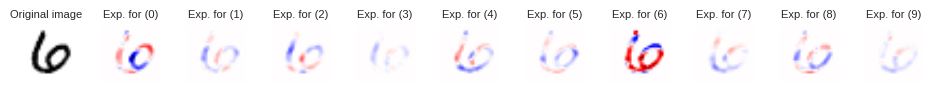

In [20]:
index = np.random.randint(55000)
print "Truth     :", np.argmax(Y[index])
print "Prediction:", np.argmax(model.predict(_X[index:index+1])[0])

plt.figure(figsize=(9.5,1))
plt.subplot(1,11,1)
plt.imshow(_X[index][:,:,0])
plt.xticks([],[])
plt.yticks([],[])
plt.title("Original image", fontsize=8)

exs = []
for i in range(1,11):
    exs.append(ig.explain(_X[index], outc=i-1))
exs = np.array(exs)

th = max(np.abs(np.min(exs)), np.abs(np.max(exs)))
print th
    
for i in range(1,11):
    ex = exs[i-1]
    plt.subplot(1,11,1+i)
    plt.imshow(ex[:,:,0], cmap="seismic", vmin=-1*th, vmax=th)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title("Exp. for ("+str(i-1)+")", fontsize=8)
plt.tight_layout()
plt.savefig("figures/"+str(index)+".png")
plt.show()